Connected to base (Python 3.11.4)

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 18 15:48:34 2023

@author: coenberns
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import datetime, timedelta, time
import pathlib 
from Plot_EGG import*
import timeit
import time
import cProfile
import sklearn
from sklearn.metrics import mean_squared_error as mse
# from Plot_EGG_adaptation import*

In [2]:
#Mac
meas_path = pathlib.Path("/Users/coenberns/Library/CloudStorage/OneDrive-MassGeneralBrigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")

# #Windows
# meas_path = pathlib.Path("C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")
# # List all the files in the selected folder
in_folder = [f for f in meas_path.iterdir() if f.is_file()]

# Print a list of available files
for i, f in enumerate(in_folder, start=1):
    print(f"{i}. {f.name}")

# Ask the user to choose a file
while True:
    try:
        choice = int(input("Enter the number of the file you want to use (1,2, etc.): "))
        if 1 <= choice <= len(in_folder):
            break
        else:
            print("Invalid choice. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Assign the selected file to a variable
file = in_folder[choice - 1]

# Now you can work with the selected_file
print(f"File selected: {file.name}")

1. 08282023_Ambulation.txt
2. 08282023_beginwithsleep.txt
3. 08282023_beforemidnight-noon_day1-2.txt
4. .DS_Store
5. 08282023_smallpartbegin_at2pm.txt
6. 08282023_smallest_fortesting.txt
7. 08282023_5plushoursevening1.txt
8. 08282023_aroundmidnight.txt
9. 08282023_1plushours-daytime1.txt
Invalid input. Please enter a number.
Invalid input. Please enter a number.
File selected: 08282023_Ambulation.txt


In [3]:
#Mac
meas_path = pathlib.Path("/Users/coenberns/Library/CloudStorage/OneDrive-MassGeneralBrigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")

# #Windows
# meas_path = pathlib.Path("C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")
# # List all the files in the selected folder
in_folder = [f for f in meas_path.iterdir() if f.is_file()]

# Print a list of available files
for i, f in enumerate(in_folder, start=1):
    print(f"{i}. {f.name}")

# Ask the user to choose a file
while True:
    try:
        choice = int(input("Enter the number of the file you want to use (1,2, etc.): "))
        if 1 <= choice <= len(in_folder):
            break
        else:
            print("Invalid choice. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Assign the selected file to a variable
file = in_folder[choice - 1]

# Now you can work with the selected_file
print(f"File selected: {file.name}")

1. 08282023_Ambulation.txt
2. 08282023_beginwithsleep.txt
3. 08282023_beforemidnight-noon_day1-2.txt
4. .DS_Store
5. 08282023_smallpartbegin_at2pm.txt
6. 08282023_smallest_fortesting.txt
7. 08282023_5plushoursevening1.txt
8. 08282023_aroundmidnight.txt
9. 08282023_Ambulation_corrected.txt
10. 08282023_1plushours-daytime1.txt
File selected: 08282023_Ambulation_corrected.txt


In [4]:
#WORKING?? ASSIGN GROUP FUNCTION
# def assign_groups(df, n_burst=5, sleep_time=2, t_deviation=0.4, n_missing=1):
#     # Part from assign_groups
#     sleep_time_min = sleep_time - t_deviation
#     sleep_time_max = sleep_time + t_deviation

#     df['numeric_misc'] = np.select(
#         [df['misc'] == " 16 ", df['misc'] == " 0a ", df['misc'] == "miss"],
#         [1, 0, np.nan]
#     )
#     df['rolling_sum'] = df['numeric_misc'].rolling(n_burst).sum()
#     df['next_sleep'] = df['numeric_misc'].shift(-n_burst)
#     df['next_burst'] = df['numeric_misc'].shift(-n_burst-1)
#     df['next_time_diff'] = df['time_diff'].shift(-n_burst-1)
    
#     # Define conditions for grouping
#     cond1 = df['numeric_misc'] == 1
#     cond2 = df['next_sleep'] == 0
#     cond3 = df['next_burst'] == 1
#     cond4 = df['rolling_sum'] == n_burst
#     cond5 = (df['next_time_diff'] >= sleep_time_min) & (df['next_time_diff'] <= sleep_time_max)
#     cond6 = df['rolling_sum'] == n_burst -n_missing

#     valid_indices = df[cond1 & cond2 & cond3 & ((cond4 & cond5) | (cond6 & cond5))].index
#     groups = [np.nan] * len(df)
#     print(valid_indices)
#     for idx, start_idx in enumerate(valid_indices):
#         end_idx = start_idx + n_burst
#         groups[start_idx:end_idx] = [idx+1] * n_burst
#     df['group'] = groups
#     #df.drop(['next_sleep', 'next_burst', 'next_time_diff', 'rolling_sum', 'numeric_misc'], axis=1, inplace=True)
#     return df

#INITIAL ASSIGN GROUPS FUNCTION
def assign_groups(df, n_burst=5, sleep_time=2, t_deviation=0.2, n_missing=1):
    """
    Standardized grouping of the low power transmission scheme using packet bursts / sleeping cycles

    n_burst: Number of recordings SENT to receiver per recording/sleep cycle
    sleep_time: amount of time the device sleeps in between recordings (in seconds)
    t_deviation: variable to define allowed deviation from sleep_time
    n_missing: amount of packets in burst that can have a NaN value after the first transmission

    Packets are grouped based on the following:
        - There are n_burst consecutive recordings of voltages without errors 
        - Sleep transmission in between
        - Consecutive value after sleep is a transmission of a packet containing voltages again
        - Exception to the rule: n_missing amount of packets in the recording contain a NaN value
        - Possibly, after the sleep transmission; next burst can have a "non-transmission" value (i.e. 'miss')
    """
    group = 0
    # List to hold group numbers
    groups = [np.nan] * len(df)
    sleep_time_min = sleep_time - t_deviation
    sleep_time_max = sleep_time + t_deviation

    for i in range(len(df) - n_burst-1):

        if df['misc'].iloc[i] == " 16 ":
            next_n_values = df['misc'].iloc[i+1:i+n_burst-1].tolist()

            # Check to see not last potential group of data
            if i <= len(df) - n_burst:
                sleep_value = df['misc'].iloc[i+n_burst]
                new_burst_value = df['misc'].iloc[i+n_burst+1]
                time_diff = df['time_diff'].iloc[i+n_burst+1]

                if all(val == " 16 " for val in next_n_values) and sleep_value == " 0a " and new_burst_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                    group += 1
                    groups[i:i+n_burst] = [group] * n_burst

                elif sum(val == "miss" for val in next_n_values) <= n_missing and sleep_value == " 0a " and new_burst_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                    group += 1
                    groups[i:i+n_burst] = [group] * n_burst

            # Check for potential last group in data
            elif i == len(df) - n_burst+1 and all(val == " 16 " for val in next_n_values):
                group += 1
                groups[i:i+(n_burst-1)] = [group] * n_burst

    df['group'] = groups
    return df

In [5]:
#INITIAL TIME DIFFERENCE CALCULATIONS
def avg_time_diffs(df, n_burst=5, sleep_time=2, t_deviation=0.2):
    """
    Calcutating the effective sampling rate, using the values of average time differences
    between i) bursts and ii) sleep packets (to get the most reliable average). 
    Average wake up time as additional output. For conversion to low power mode, due to 
    rec/sleep cycling the sampling rate is slightly altered. This needs to be taken into 
    account to make sure the received values of the times and voltages can be used for 
    further analysis. 

    Inputs:     
        n_burst: Number of recordings SENT to receiver per recording/sleep cycle
        sleep_time: amount of time the device sleeps in between recordings (in seconds)
        t_deviation: variable to define allowed deviation from sleep_time

    Outputs:
        avg_burst_diff: Average time between the average burst difference
        avg_sleep_time: Average time between sleep packets received
        avg_wake_up_time: Average time between the sleep packet and new transmission - sleep time 
        effective_rate: the effective sampling rate
        - 
    """

    df_burst = df.copy()
    df_sleep = df.copy()
    sleep_time_min = sleep_time - t_deviation
    sleep_time_max = sleep_time + t_deviation

    # Calculate the average wake up time based on the sleep time and the time difference between sleep and next packet
    sleep_times = []
    wake_up_times = []
    for i in range(len(df_sleep)-1):
        if df_sleep['misc'].iloc[i] == " 0a ":
            next_value = df_sleep['misc'].iloc[i+1]
            time_diff = df_sleep['time_diff'].iloc[i+1]
            if next_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                sleep_times.append(time_diff)
                wake_up_time = time_diff - sleep_time
                wake_up_times.append(wake_up_time)

    if sleep_times:
        avg_sleep_time = sum(sleep_times)/len(sleep_times)
    else:
        sleep_times = 0
    
    if wake_up_times:
        avg_wake_up_time = sum(wake_up_times)/len(wake_up_times)
    else:
        avg_wake_up_time = 0

    burst_times = []
    for i in range(len(df_burst)-n_burst-1):
        if (df_burst['misc'].iloc[i] == " 16 ") and (not np.isnan(df_burst['group'].iloc[i])):
            first_burst = df_burst['packet_re_idx'].iloc[i]
            last_burst = df_burst['packet_re_idx'].iloc[i+n_burst-1]

            # Check if all values in the range are "16"
            next_value_cat = df_burst['misc'].iloc[i+1:i+n_burst]
            if all(val == " 16 " for val in next_value_cat):
                
                next_values = df_burst['time_diff'].iloc[i+1:i+n_burst]
                if (last_burst - first_burst == n_burst - 1):
                    burst_times.append(next_values.sum())
    if burst_times:
        avg_burst_time = sum(burst_times)/len(burst_times)
    else:
        avg_burst_time = 0
    # Average time between sample bursts and effective sampling rate in SPS
    #avg_time_between = np.mean([avg_burst_diff, avg_sleep_time])
    avg_time_between = avg_burst_time+avg_sleep_time
    effective_rate = 1 / avg_time_between

    return avg_time_between, effective_rate, avg_wake_up_time, avg_sleep_time, avg_burst_time, burst_times

In [6]:
    ## COMMENTED OUT FOR NOW
    #         
    # # Calculate the time difference between the different sleep transmissions
    # # Dataframe with only sleep packets
    # # df_sleep = df_sleep[df_sleep['misc'] == " 0a "]
    # # # Calculate time difference in between sleep packets
    # # # df_sleep['time_diff'] = df_sleep['realtime'].diff().dt.total_seconds()
    # # # df_sleep = df_sleep[df_sleep['time_diff'] >= sleep_time_min]
    # # # df_sleep = df_sleep[df_sleep['time_diff'] <= sleep_time_max]
    # # # avg_sleep_time = df_sleep['time_diff'].mean()
    # # Calculate the sum of time differences per group to average per groups, then calculate the time average between these
    # # Filter out group = nan rows for burst groups
    # df_burst.dropna(subset=['group'], inplace=True)
    # # Calculate summed delta t per group
    # group_time_diff = df_burst.groupby('group')['time_diff'].sum()
    # # Identify valid groups where summed delta t
    # valid_groups = group_time_diff[(group_time_diff >= sleep_time_min) & (
    #     group_time_diff <= sleep_time_max)].index.tolist()
    # # Filter out invalid groups
    # df_burst = df_burst[df_burst['group'].isin(valid_groups)]
    # # Assign the  summed delta t per group back to df_burst for potential later use
    # df_burst['group_time_diff'] = df_burst['group'].map(group_time_diff)
    # # Calculate the average time difference across valid groups
    # avg_burst_diff = group_time_diff[valid_groups].mean()

In [7]:
#MASTER FUNCTION
def read_egg_v3_lowerP(file,
                       header=0,
                       rate = 62.5,
                       scale=600,
                       error=0,
                       date=None,
                       n_burst=5,
                       sleep_ping=1,
                       sleep_time=2,
                       t_deviation=0.2,
                       start_sleep=240,
                       n_missing=1,
                       mean = True):
    """
    This function reads in and preprocesses the data from a text file generated by smartRF from 
    EGG_V3 when the recording mode is set to low power mode (Mode 2 or 3). 
    Inputs: 
        file : filepath of the target txt file
        header : Number of lines to skip
        scale : +- scale in mV 
        error : returns data with CRC errors. Default is 0 so those are stripped
        date : The date of the recording (automatically fetched if in beginning of txt file if format: MMDDYYYY_textfilename.txt)
        n_burst: Number of recordings SENT to receiver per recording/sleep cycle
        sleep_time: amount of time the device sleeps in between recordings (in seconds)
        t_deviation: variable to define allowed deviation from sleep_time
        n_missing: amount of packets in burst that can have a NaN value after the first transmission

    Outputs:
        VT_data: Voltage time data, use timestamps for time (others are indication of functionality, first two can be left out)
            .avg_elapsed_t: datetime object which contains the average elapsed time of a group (1, just for indication of difference)
            .avg_elapsed_s: The average elapsed time of the group, from start, in seconds (2, just for indication of difference)
            .packet_re_idx: The re-indexed packet number (zero is first voltage packet, note: this can be renamed "counter" if necessary)
            .group: group numbers based on the assign_groups() function 
            .Channel {i}: mean voltage per group for all channels
            .timestamps: The evenly spaced time variable, based on avg_time_between and the packet number divided by 6
        grouped_fulldat: The full dataset, grouped based on the assign_groups() function
        volt_fulldat: The dataset including all voltages, average and raw and all other columns as in grouped_fulldat (sleep and missing are dropped)
        avg_time_between: The average time between the sample bursts as calculated by avg_time_diffs() 
        effective_rate: The effective sampling rate based on the avg_time_between(*) (=1/*)

    """
    complete_start = time.time()
    # Putting in the date information to create complete datetime object, if information available
    if date is None:
        # get only the filename from the file path
        file_path = pathlib.Path(file)
        filename = file_path.name
        # extract date from the filename
        date = filename.split('_')[0]

    # Creating datetime object
    # which takes in "MMDDYYYY" like only US people write date order
    date = datetime.strptime(date, '%m%d%Y')
    start_time1 = time.time()
    dat = pd.read_csv(file, header=0, dtype=str, delimiter='|', names=[
        'realtime', 'misc', 'packet', 'msg', 'rssi'])
    end_time1 = time.time()
    print("reading csv file time: ", end_time1-start_time1)

    start_timer_dat = time.time()
    dat = dat[~dat.rssi.str.contains('error')]
    dat = dat[dat.misc.str.contains('16') | dat.misc.str.contains('0a')]
    dat = dat.reset_index(drop=True)
    end_timer_dat = time.time()
    print("Initial data conversion: ", end_timer_dat-start_timer_dat)
    counter_timer = time.time()
    counter = dat.packet.astype(int)
    new_counter = [0]
    for j, ele in enumerate(counter[1:]):
        step = counter[j+1]-counter[j]
        if step > 0:
            new_counter.append(step+new_counter[j])
        else:
            new_counter.append(65536-counter[j]+counter[j+1]+new_counter[j])
            print('flip', step, 65536-counter[j]+counter[j+1])
    abscounterseries = pd.Series(new_counter, name='packet_re_idx')
    counter_end_timer = time.time()
    print("Time for new counter: ", counter_end_timer-counter_timer)

    dat = pd.concat((dat, abscounterseries), axis=1)
    
    
    # Creating a datetime object from realtime, recalling it realtime (since it still is)
    datetime_counter = time.time()
    dat["realtime"] = dat["realtime"].str.strip()
    dat["realtime"] = pd.to_datetime(dat["realtime"], format='%H:%M:%S.%f')
    dat["realtime"] = dat["realtime"].apply(
        lambda t: datetime.combine(date, t.time()))
    # Check for date rollover and increment the date if necessary, with additional glitch values excluded
    dat['time_diff'] = dat['realtime'].diff().dt.total_seconds()
    dat['rollover'] = dat['time_diff'] < 0
    dat['glitch'] = (dat['time_diff'] > -5) & (dat['rollover'])

    n_glitch = 50
    dat['glitch'] = dat['glitch'].rolling(window=n_glitch, min_periods=1).max().astype(bool)
    dat.loc[dat['glitch'], 'realtime'] = np.nan
    dat['correct_rollover'] = dat['rollover'] & ~dat['glitch'] 
    dat['days_to_add'] = dat['correct_rollover'].cumsum()
    dat['corrected_realtime'] = dat['realtime'] + pd.to_timedelta(dat['days_to_add'], unit='D')
    # dat['corrected_realtime'].interpolate(method='linear', inplace=True)

    # probably delete this if timestamps values at end are close to elapsed_s
    dat['elapsed_t'] = dat['corrected_realtime'] - dat['corrected_realtime'].iloc[0]
    print("elapsed t could be printed!!!!")
    print(dat['elapsed_t'])
    datetime_end_counter = time.time()
    print("Time for datetime conversion :", datetime_end_counter-datetime_counter)

    hexdat_counter = time.time()
    dat_col = dat.msg
    # Return list of splits based on spaces in msg
    hexdat = dat_col.str.split(' ')
    serieslist = []
    sleep_pings = []  # List to store sleep pings
    for k, ele in enumerate(hexdat):
        if len(ele) == 23:  # Only select those that have the correct length for voltage data
            vlist = []
            for i in range(0, 10):
                n = i*2 + 2
                value = ''.join(['0x', ele[n], ele[n-1]])
                hvalue = int(value, 16)
                if i == 0:
                    vlist.append(hvalue)  # append hex code
                else:
                    if hvalue < 2**15:
                        vlist.append(scale*float(hvalue)/(2**15))
                    else:
                        vlist.append(scale*(((float(hvalue)-2**16)/(2**15))))
        elif len(ele) == 11:  # This is a sleep packet
            # Extract the number of pings from the first two bytes of the message and convert to integer
            ping_value = int(''.join(['0x', ele[1], ele[0]]), 16)
            sleep_pings.append(ping_value)
            # Fill the remaining places with None to maintain vlist structure
            vlist = [ping_value] + [None]*9
        else:  # Error in packet structure
            print('Line Error!' + str(k))
            print(ele)
            vlist = []  # add empty list on error
        serieslist.append(vlist)
    hexdat_end_counter = time.time()
    print("Time for hexdat: ", hexdat_end_counter-hexdat_counter)
    collist = ['SPI']
    for i in range(8):
        collist.append('Channel '+str(i))  # make channel list name
    collist.append('CRC')
    datalist = pd.DataFrame(serieslist, columns=collist)
    # print(datalist)
    fulldat = pd.concat((dat, datalist), axis=1)
    print(fulldat)
    missing_packets_counter = time.time()
    # packet counter with actual packet values, seeing if we miss packets
    expected_packets = list(
        range(min(fulldat['packet_re_idx']), max(fulldat['packet_re_idx'])+1))
    missing_packets = list(set(expected_packets) - set(fulldat['packet_re_idx'].to_list()))
    missing_rows = pd.DataFrame(
        [{'misc': 'miss', 'packet_re_idx': re_idx} for re_idx in missing_packets])
    fulldat = pd.concat([fulldat, missing_rows], ignore_index=True)
    fulldat = fulldat.sort_values(by='packet_re_idx').reset_index(drop=True)
    missing_packet_end_counter = time.time()
    print("missing packets: ", missing_packet_end_counter-missing_packets_counter)
    # Assigning groups to fulldat valid bursts
    start_time2=time.time()
    grouped_fulldat = assign_groups(fulldat,
                                    n_burst=n_burst,
                                    sleep_time=sleep_time,
                                    t_deviation=t_deviation,
                                    n_missing=n_missing)
    end_time2=time.time()
    print("grouping function: ", end_time2-start_time2)
    start_avg_times = time.time()
    avg_time_between, effective_rate, avg_wake_up_time,\
        avg_sleep_time, avg_burst_time, burst_times = avg_time_diffs(df=fulldat,
                                                                    n_burst=n_burst,
                                                                    sleep_time=sleep_time,
                                                                    t_deviation=t_deviation
                                                                    )                                        
    end_avg_times = time.time()
    print("Calculating average times: ", end_avg_times-start_avg_times)
    #CONDITION IF WE WANT MEAN VALUES
    if mean == True:
        # Final processing steps
        volt_fulldat = grouped_fulldat.copy()
        # Don't know how to change since timestamps dependent on re-indexing to first voltage value
        volt_fulldat = volt_fulldat.dropna()
        volt_fulldat['avg_elapsed_t'] = volt_fulldat.groupby(
            'group')['elapsed_t'].transform('mean')
        volt_fulldat['avg_elapsed_start'] = volt_fulldat['avg_elapsed_t'] - \
            volt_fulldat['avg_elapsed_t'].iloc[0]
        volt_fulldat['avg_elapsed_s'] = volt_fulldat['avg_elapsed_start'].dt.total_seconds()
        # # Storing RAW voltage data just in case
        # for i in range(8):
        #     volt_fulldat[f'RAW Channel {i}'] = volt_fulldat[f'Channel {i}']
        # Mean voltage calculations
        for i in range(8):
            channel = f'Channel {i}'
            # Calculate mean and directly store in the Channel columns, overwriting old data
            volt_fulldat[channel] = volt_fulldat.groupby(
                'group')[channel].transform('mean')
        # calculation of timestamps based on function, would like to put here
        volt_fulldat['packet_re_idx'] = volt_fulldat['packet_re_idx'] - \
            volt_fulldat['packet_re_idx'].iloc[0]
        #Introduce again the missing packets when they are divisible by 6
        expected_packets_mean = list(
            range(min(volt_fulldat['packet_re_idx']), max(volt_fulldat['packet_re_idx']) + 1))
        print("All expected packets: ", expected_packets_mean)
        missing_packets_mean = list(set(expected_packets_mean) - 
                                    set(volt_fulldat['packet_re_idx'].to_list()))
        missing_packets_divisible = [pkt for pkt in missing_packets_mean if pkt % (n_burst+1) == 0]
        print("Divisible packets: ", missing_packets_divisible)
        missing_rows_mean = pd.DataFrame(
            [{'misc': 'miss', 'packet_re_idx': re_idx} for re_idx in missing_packets_divisible]
        )
        print("Missing row dataframe: ", missing_rows_mean)
        volt_fulldat = pd.concat([volt_fulldat, missing_rows_mean], ignore_index=True)
        volt_fulldat = volt_fulldat.sort_values(by='packet_re_idx').reset_index(drop=True)
        volt_fulldat['timestamps'] = volt_fulldat['packet_re_idx'] / \
            ((n_burst+1))*avg_time_between
        #Dropping all the duplicates, but still keep the newly introduced na values (with timestamps)
        mask = (~volt_fulldat['group'].duplicated(keep='first')) | volt_fulldat['group'].isna()
        volt_fulldat = volt_fulldat[mask]
        #correcting for the final value difference using delta_t at the end
        delta_t_finish = (abs(volt_fulldat['avg_elapsed_s'].max()-volt_fulldat['timestamps'].max())/((volt_fulldat['packet_re_idx'].max()/6)-1))*(n_burst+1)

        # Initialize a new column to store the updated timestamps
        volt_fulldat['new_timestamps'] = volt_fulldat['timestamps']

        # Counter for the number of times add_value should be added
        counter = 0

        # Iterate over the DataFrame by index
        for idx in volt_fulldat.index:
            # If the current index is in packet_re_idx, add add_value to the 'new_timestamps' column
            if idx % 6 == 0:  # Adjust the condition based on your requirement
                counter += 1
            # Update the 'new_timestamps' by adding add_value multiplied by the counter
            volt_fulldat.at[idx, 'new_timestamps'] += delta_t_finish * counter

        datcols = ['corrected_realtime','avg_elapsed_s', 'timestamps',
                'packet_re_idx', 'group'] + [f'Channel {i}' for i in range(8)]
        # Calculating Voltage time data
        VT_data = volt_fulldat[datcols]
    #NON-MEAN PRE-PROCESSING
    else:
        grouped_fulldat1 = grouped_fulldat[grouped_fulldat['misc'] == " 16 "]
        groupdat = grouped_fulldat1.copy()
        groupdat['packet_re_idx'] = groupdat['packet_re_idx']-groupdat['packet_re_idx'].iloc[0]
        groupdat['packet_start_idx'] = groupdat['packet_re_idx']
        expected_packets = list(
        range(min(groupdat['packet_start_idx']), max(groupdat['packet_start_idx'])+1))
        missing_packets = list(set(expected_packets) - set(groupdat['packet_start_idx'].to_list()))
        missing_rows = pd.DataFrame(
        [{'misc': 'miss', 'packet_start_idx': re_idx} for re_idx in missing_packets])
        groupdat = pd.concat([groupdat, missing_rows], ignore_index=True)
        groupdat = groupdat.sort_values(by='packet_start_idx').reset_index(drop=True)
        #Time projection function 1 - including correction
        tarray = []
        for number in groupdat['packet_start_idx']:
            burst_time = np.floor((number)/(n_burst+sleep_ping))*avg_time_between
            packet_time = ((number) % (n_burst+sleep_ping))*(avg_burst_time/(n_burst-1))
            tarray.append(float(burst_time)+packet_time)
        
        tseries = pd.Series(tarray,name='timestamps_f1')
        groupdat['elapsed_t'] = groupdat['elapsed_t']-groupdat['elapsed_t'].iloc[0]
        groupdat['elapsed_s'] = groupdat['elapsed_t'].dt.total_seconds()
        volt_fulldat = groupdat.reset_index(drop=True)
        volt_fulldat = pd.concat((volt_fulldat,tseries), axis=1)
        delta_t_finish = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f1'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_series = pd.Series([delta_t_finish]*len(volt_fulldat))
        delta_t_series = delta_t_series.cumsum()
        delta_t_series -= delta_t_finish
        volt_fulldat['corrected_t_f1'] = volt_fulldat['timestamps_f1'] + delta_t_series
        
        #Time projection function 2 - including correction
        t_cycle = (volt_fulldat['elapsed_s'].max()/volt_fulldat['packet_start_idx'].max())*6
        tarray_2 = []
        for number2 in groupdat['packet_start_idx']:
            burst_time2 = np.floor((number2)/(n_burst+sleep_ping))*t_cycle
            packet_time2 = ((number2) % (n_burst+sleep_ping))*(1/rate)
            tarray_2.append(float(burst_time2)+packet_time2)
        tseries2 = pd.Series(tarray_2, name='timestamps_f2')
        #Time projection function 3 - including correction
        tarray_3 = []
        for number3 in groupdat['packet_start_idx']:
            burst_time3 = np.floor((number3)/(n_burst+sleep_ping))*t_cycle
            packet_time3 = ((number3) % (n_burst+sleep_ping))*(avg_burst_time/(n_burst-1))
            tarray_3.append(float(burst_time3)+packet_time3)
        tseries3 = pd.Series(tarray_3, name='timestamps_f3')

        #For function 2
        volt_fulldat = pd.concat([volt_fulldat,tseries2,tseries3],axis=1)
        delta_t_f2 = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f2'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_f2_series = pd.Series([delta_t_f2]*len(volt_fulldat))
        delta_t_f2_series = delta_t_f2_series.cumsum()
        delta_t_f2_series -= delta_t_f2
        volt_fulldat['corrected_t_f2'] = volt_fulldat['timestamps_f2']+delta_t_f2_series
        delta_t_f3 = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f3'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_f3_series = pd.Series([delta_t_f3]*len(volt_fulldat))
        delta_t_f3_series = delta_t_f3_series.cumsum()
        delta_t_f3_series -= delta_t_f3
        volt_fulldat['corrected_t_f3'] = volt_fulldat['timestamps_f3']+delta_t_f3_series
        datcols = ['corrected_realtime','elapsed_s','timestamps_f1','timestamps_f2','timestamps_f3', 
                   'corrected_t_f1','corrected_t_f2', 'corrected_t_f3', 'packet_start_idx'] + [f'Channel {i}' for i in range(8)]
        VT_data = volt_fulldat[datcols]


    complete_end = time.time()
    print("Total time to complete function: ", complete_end-complete_start)

    return fulldat, VT_data, grouped_fulldat, \
        volt_fulldat, avg_time_between, effective_rate,\
            avg_wake_up_time, avg_sleep_time, avg_burst_time, burst_times

In [8]:
fulldat, VT_data, grouped_fulldat,\
    volt_fulldat, avg_time_between, effective_rate,\
        avg_wake_up_time, avg_sleep_time, avg_burst_time,\
            burst_times = read_egg_v3_lowerP(file,
                                            header=0,
                                            rate=62.5,
                                            scale=600,
                                            error=0,
                                            date=None,
                                            n_burst=5,
                                            sleep_ping=1,
                                            sleep_time=1.84,
                                            t_deviation=0.2,
                                            start_sleep=142,
                                            n_missing=1,
                                            mean=False
                                            )

reading csv file time:  0.45247507095336914
Initial data conversion:  0.29087376594543457
flip -65535 1
flip -65361 175
flip -65535 1
flip -65535 1
flip -65498 38
flip -65535 1
Time for new counter:  1.4097740650177002
elapsed t could be printed!!!!
0               0 days 00:00:00
1        0 days 00:00:59.999000
2        0 days 00:01:59.998000
3        0 days 00:02:59.996000
4        0 days 00:04:59.995000
                  ...          
245096   1 days 20:25:34.959000
245097   1 days 20:25:36.904000
245098   1 days 20:25:36.952000
245099   1 days 20:25:36.999000
245100   1 days 20:25:36.999000
Name: elapsed_t, Length: 245101, dtype: timedelta64[ns]
Time for datetime conversion : 0.9097802639007568
Time for hexdat:  2.388976812362671
                      realtime  misc   packet  \
0      2023-08-28 12:09:05.310   0a     0099    
1      2023-08-28 12:10:05.309   0a     0100    
2      2023-08-28 12:11:05.308   0a     0101    
3      2023-08-28 12:12:05.306   0a     0102    
4      2023

In [9]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-9-219bd2590633>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-9-219bd2590633>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-9-219bd2590633>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [10]:
#Mac
meas_path = pathlib.Path("/Users/coenberns/Library/CloudStorage/OneDrive-MassGeneralBrigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")

# #Windows
# meas_path = pathlib.Path("C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")
# # List all the files in the selected folder
in_folder = [f for f in meas_path.iterdir() if f.is_file()]

# Print a list of available files
for i, f in enumerate(in_folder, start=1):
    print(f"{i}. {f.name}")

# Ask the user to choose a file
while True:
    try:
        choice = int(input("Enter the number of the file you want to use (1,2, etc.): "))
        if 1 <= choice <= len(in_folder):
            break
        else:
            print("Invalid choice. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Assign the selected file to a variable
file = in_folder[choice - 1]

# Now you can work with the selected_file
print(f"File selected: {file.name}")

1. 08282023_Ambulation.txt
2. 08282023_beginwithsleep.txt
3. 08282023_beforemidnight-noon_day1-2.txt
4. .DS_Store
5. 08282023_smallpartbegin_at2pm.txt
6. 08282023_smallest_fortesting.txt
7. 08282023_5plushoursevening1.txt
8. 08282023_aroundmidnight.txt
9. 08282023_Ambulation_corrected.txt
10. 08282023_1plushours-daytime1.txt
File selected: 08282023_Ambulation_corrected.txt


In [11]:
#WORKING?? ASSIGN GROUP FUNCTION
# def assign_groups(df, n_burst=5, sleep_time=2, t_deviation=0.4, n_missing=1):
#     # Part from assign_groups
#     sleep_time_min = sleep_time - t_deviation
#     sleep_time_max = sleep_time + t_deviation

#     df['numeric_misc'] = np.select(
#         [df['misc'] == " 16 ", df['misc'] == " 0a ", df['misc'] == "miss"],
#         [1, 0, np.nan]
#     )
#     df['rolling_sum'] = df['numeric_misc'].rolling(n_burst).sum()
#     df['next_sleep'] = df['numeric_misc'].shift(-n_burst)
#     df['next_burst'] = df['numeric_misc'].shift(-n_burst-1)
#     df['next_time_diff'] = df['time_diff'].shift(-n_burst-1)
    
#     # Define conditions for grouping
#     cond1 = df['numeric_misc'] == 1
#     cond2 = df['next_sleep'] == 0
#     cond3 = df['next_burst'] == 1
#     cond4 = df['rolling_sum'] == n_burst
#     cond5 = (df['next_time_diff'] >= sleep_time_min) & (df['next_time_diff'] <= sleep_time_max)
#     cond6 = df['rolling_sum'] == n_burst -n_missing

#     valid_indices = df[cond1 & cond2 & cond3 & ((cond4 & cond5) | (cond6 & cond5))].index
#     groups = [np.nan] * len(df)
#     print(valid_indices)
#     for idx, start_idx in enumerate(valid_indices):
#         end_idx = start_idx + n_burst
#         groups[start_idx:end_idx] = [idx+1] * n_burst
#     df['group'] = groups
#     #df.drop(['next_sleep', 'next_burst', 'next_time_diff', 'rolling_sum', 'numeric_misc'], axis=1, inplace=True)
#     return df

#INITIAL ASSIGN GROUPS FUNCTION
def assign_groups(df, n_burst=5, sleep_time=2, t_deviation=0.2, n_missing=1):
    """
    Standardized grouping of the low power transmission scheme using packet bursts / sleeping cycles

    n_burst: Number of recordings SENT to receiver per recording/sleep cycle
    sleep_time: amount of time the device sleeps in between recordings (in seconds)
    t_deviation: variable to define allowed deviation from sleep_time
    n_missing: amount of packets in burst that can have a NaN value after the first transmission

    Packets are grouped based on the following:
        - There are n_burst consecutive recordings of voltages without errors 
        - Sleep transmission in between
        - Consecutive value after sleep is a transmission of a packet containing voltages again
        - Exception to the rule: n_missing amount of packets in the recording contain a NaN value
        - Possibly, after the sleep transmission; next burst can have a "non-transmission" value (i.e. 'miss')
    """
    group = 0
    # List to hold group numbers
    groups = [np.nan] * len(df)
    sleep_time_min = sleep_time - t_deviation
    sleep_time_max = sleep_time + t_deviation

    for i in range(len(df) - n_burst-1):

        if df['misc'].iloc[i] == " 16 ":
            next_n_values = df['misc'].iloc[i+1:i+n_burst-1].tolist()

            # Check to see not last potential group of data
            if i <= len(df) - n_burst:
                sleep_value = df['misc'].iloc[i+n_burst]
                new_burst_value = df['misc'].iloc[i+n_burst+1]
                time_diff = df['time_diff'].iloc[i+n_burst+1]

                if all(val == " 16 " for val in next_n_values) and sleep_value == " 0a " and new_burst_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                    group += 1
                    groups[i:i+n_burst] = [group] * n_burst

                elif sum(val == "miss" for val in next_n_values) <= n_missing and sleep_value == " 0a " and new_burst_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                    group += 1
                    groups[i:i+n_burst] = [group] * n_burst

            # Check for potential last group in data
            elif i == len(df) - n_burst+1 and all(val == " 16 " for val in next_n_values):
                group += 1
                groups[i:i+(n_burst-1)] = [group] * n_burst

    df['group'] = groups
    return df

In [12]:
#INITIAL TIME DIFFERENCE CALCULATIONS
def avg_time_diffs(df, n_burst=5, sleep_time=2, t_deviation=0.2):
    """
    Calcutating the effective sampling rate, using the values of average time differences
    between i) bursts and ii) sleep packets (to get the most reliable average). 
    Average wake up time as additional output. For conversion to low power mode, due to 
    rec/sleep cycling the sampling rate is slightly altered. This needs to be taken into 
    account to make sure the received values of the times and voltages can be used for 
    further analysis. 

    Inputs:     
        n_burst: Number of recordings SENT to receiver per recording/sleep cycle
        sleep_time: amount of time the device sleeps in between recordings (in seconds)
        t_deviation: variable to define allowed deviation from sleep_time

    Outputs:
        avg_burst_diff: Average time between the average burst difference
        avg_sleep_time: Average time between sleep packets received
        avg_wake_up_time: Average time between the sleep packet and new transmission - sleep time 
        effective_rate: the effective sampling rate
        - 
    """

    df_burst = df.copy()
    df_sleep = df.copy()
    sleep_time_min = sleep_time - t_deviation
    sleep_time_max = sleep_time + t_deviation

    # Calculate the average wake up time based on the sleep time and the time difference between sleep and next packet
    sleep_times = []
    wake_up_times = []
    for i in range(len(df_sleep)-1):
        if df_sleep['misc'].iloc[i] == " 0a ":
            next_value = df_sleep['misc'].iloc[i+1]
            time_diff = df_sleep['time_diff'].iloc[i+1]
            if next_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                sleep_times.append(time_diff)
                wake_up_time = time_diff - sleep_time
                wake_up_times.append(wake_up_time)

    if sleep_times:
        avg_sleep_time = sum(sleep_times)/len(sleep_times)
    else:
        sleep_times = 0
    
    if wake_up_times:
        avg_wake_up_time = sum(wake_up_times)/len(wake_up_times)
    else:
        avg_wake_up_time = 0

    burst_times = []
    for i in range(len(df_burst)-n_burst-1):
        if (df_burst['misc'].iloc[i] == " 16 ") and (not np.isnan(df_burst['group'].iloc[i])):
            first_burst = df_burst['packet_re_idx'].iloc[i]
            last_burst = df_burst['packet_re_idx'].iloc[i+n_burst-1]

            # Check if all values in the range are "16"
            next_value_cat = df_burst['misc'].iloc[i+1:i+n_burst]
            if all(val == " 16 " for val in next_value_cat):
                
                next_values = df_burst['time_diff'].iloc[i+1:i+n_burst]
                if (last_burst - first_burst == n_burst - 1):
                    burst_times.append(next_values.sum())
    if burst_times:
        avg_burst_time = sum(burst_times)/len(burst_times)
    else:
        avg_burst_time = 0
    # Average time between sample bursts and effective sampling rate in SPS
    #avg_time_between = np.mean([avg_burst_diff, avg_sleep_time])
    avg_time_between = avg_burst_time+avg_sleep_time
    effective_rate = 1 / avg_time_between

    return avg_time_between, effective_rate, avg_wake_up_time, avg_sleep_time, avg_burst_time, burst_times

In [13]:
    ## COMMENTED OUT FOR NOW
    #         
    # # Calculate the time difference between the different sleep transmissions
    # # Dataframe with only sleep packets
    # # df_sleep = df_sleep[df_sleep['misc'] == " 0a "]
    # # # Calculate time difference in between sleep packets
    # # # df_sleep['time_diff'] = df_sleep['realtime'].diff().dt.total_seconds()
    # # # df_sleep = df_sleep[df_sleep['time_diff'] >= sleep_time_min]
    # # # df_sleep = df_sleep[df_sleep['time_diff'] <= sleep_time_max]
    # # # avg_sleep_time = df_sleep['time_diff'].mean()
    # # Calculate the sum of time differences per group to average per groups, then calculate the time average between these
    # # Filter out group = nan rows for burst groups
    # df_burst.dropna(subset=['group'], inplace=True)
    # # Calculate summed delta t per group
    # group_time_diff = df_burst.groupby('group')['time_diff'].sum()
    # # Identify valid groups where summed delta t
    # valid_groups = group_time_diff[(group_time_diff >= sleep_time_min) & (
    #     group_time_diff <= sleep_time_max)].index.tolist()
    # # Filter out invalid groups
    # df_burst = df_burst[df_burst['group'].isin(valid_groups)]
    # # Assign the  summed delta t per group back to df_burst for potential later use
    # df_burst['group_time_diff'] = df_burst['group'].map(group_time_diff)
    # # Calculate the average time difference across valid groups
    # avg_burst_diff = group_time_diff[valid_groups].mean()

In [14]:
#MASTER FUNCTION
def read_egg_v3_lowerP(file,
                       header=0,
                       rate = 62.5,
                       scale=600,
                       error=0,
                       date=None,
                       n_burst=5,
                       sleep_ping=1,
                       sleep_time=2,
                       t_deviation=0.2,
                       start_sleep=240,
                       n_missing=1,
                       mean = True):
    """
    This function reads in and preprocesses the data from a text file generated by smartRF from 
    EGG_V3 when the recording mode is set to low power mode (Mode 2 or 3). 
    Inputs: 
        file : filepath of the target txt file
        header : Number of lines to skip
        scale : +- scale in mV 
        error : returns data with CRC errors. Default is 0 so those are stripped
        date : The date of the recording (automatically fetched if in beginning of txt file if format: MMDDYYYY_textfilename.txt)
        n_burst: Number of recordings SENT to receiver per recording/sleep cycle
        sleep_time: amount of time the device sleeps in between recordings (in seconds)
        t_deviation: variable to define allowed deviation from sleep_time
        n_missing: amount of packets in burst that can have a NaN value after the first transmission

    Outputs:
        VT_data: Voltage time data, use timestamps for time (others are indication of functionality, first two can be left out)
            .avg_elapsed_t: datetime object which contains the average elapsed time of a group (1, just for indication of difference)
            .avg_elapsed_s: The average elapsed time of the group, from start, in seconds (2, just for indication of difference)
            .packet_re_idx: The re-indexed packet number (zero is first voltage packet, note: this can be renamed "counter" if necessary)
            .group: group numbers based on the assign_groups() function 
            .Channel {i}: mean voltage per group for all channels
            .timestamps: The evenly spaced time variable, based on avg_time_between and the packet number divided by 6
        grouped_fulldat: The full dataset, grouped based on the assign_groups() function
        volt_fulldat: The dataset including all voltages, average and raw and all other columns as in grouped_fulldat (sleep and missing are dropped)
        avg_time_between: The average time between the sample bursts as calculated by avg_time_diffs() 
        effective_rate: The effective sampling rate based on the avg_time_between(*) (=1/*)

    """
    complete_start = time.time()
    # Putting in the date information to create complete datetime object, if information available
    if date is None:
        # get only the filename from the file path
        file_path = pathlib.Path(file)
        filename = file_path.name
        # extract date from the filename
        date = filename.split('_')[0]

    # Creating datetime object
    # which takes in "MMDDYYYY" like only US people write date order
    date = datetime.strptime(date, '%m%d%Y')
    start_time1 = time.time()
    dat = pd.read_csv(file, header=0, dtype=str, delimiter='|', names=[
        'realtime', 'misc', 'packet', 'msg', 'rssi'])
    end_time1 = time.time()
    print("reading csv file time: ", end_time1-start_time1)

    start_timer_dat = time.time()
    dat = dat[~dat.rssi.str.contains('error')]
    dat = dat[dat.misc.str.contains('16') | dat.misc.str.contains('0a')]
    dat = dat.reset_index(drop=True)
    end_timer_dat = time.time()
    print("Initial data conversion: ", end_timer_dat-start_timer_dat)
    counter_timer = time.time()
    counter = dat.packet.astype(int)
    new_counter = [0]
    for j, ele in enumerate(counter[1:]):
        step = counter[j+1]-counter[j]
        if step > 0:
            new_counter.append(step+new_counter[j])
        else:
            new_counter.append(65536-counter[j]+counter[j+1]+new_counter[j])
            print('flip', step, 65536-counter[j]+counter[j+1])
    abscounterseries = pd.Series(new_counter, name='packet_re_idx')
    counter_end_timer = time.time()
    print("Time for new counter: ", counter_end_timer-counter_timer)

    dat = pd.concat((dat, abscounterseries), axis=1)
    
    
    # Creating a datetime object from realtime, recalling it realtime (since it still is)
    datetime_counter = time.time()
    dat["realtime"] = dat["realtime"].str.strip()
    dat["realtime"] = pd.to_datetime(dat["realtime"], format='%H:%M:%S.%f')
    dat["realtime"] = dat["realtime"].apply(
        lambda t: datetime.combine(date, t.time()))
    # Check for date rollover and increment the date if necessary, with additional glitch values excluded
    dat['time_diff'] = dat['realtime'].diff().dt.total_seconds()
    dat['rollover'] = dat['time_diff'] < 0
    dat['glitch'] = (dat['time_diff'] > -5) & (dat['rollover'])

    n_glitch = 50
    dat['glitch'] = dat['glitch'].rolling(window=n_glitch, min_periods=1).max().astype(bool)
    dat.loc[dat['glitch'], 'realtime'] = np.nan
    dat['correct_rollover'] = dat['rollover'] & ~dat['glitch'] 
    dat['days_to_add'] = dat['correct_rollover'].cumsum()
    dat['corrected_realtime'] = dat['realtime'] + pd.to_timedelta(dat['days_to_add'], unit='D')
    # dat['corrected_realtime'].interpolate(method='linear', inplace=True)

    # probably delete this if timestamps values at end are close to elapsed_s
    dat['elapsed_t'] = dat['corrected_realtime'] - dat['corrected_realtime'].iloc[0]
    print("elapsed t could be printed!!!!")
    print(dat['elapsed_t'])
    datetime_end_counter = time.time()
    print("Time for datetime conversion :", datetime_end_counter-datetime_counter)

    hexdat_counter = time.time()
    dat_col = dat.msg
    # Return list of splits based on spaces in msg
    hexdat = dat_col.str.split(' ')
    serieslist = []
    sleep_pings = []  # List to store sleep pings
    for k, ele in enumerate(hexdat):
        if len(ele) == 23:  # Only select those that have the correct length for voltage data
            vlist = []
            for i in range(0, 10):
                n = i*2 + 2
                value = ''.join(['0x', ele[n], ele[n-1]])
                hvalue = int(value, 16)
                if i == 0:
                    vlist.append(hvalue)  # append hex code
                else:
                    if hvalue < 2**15:
                        vlist.append(scale*float(hvalue)/(2**15))
                    else:
                        vlist.append(scale*(((float(hvalue)-2**16)/(2**15))))
        elif len(ele) == 11:  # This is a sleep packet
            # Extract the number of pings from the first two bytes of the message and convert to integer
            ping_value = int(''.join(['0x', ele[1], ele[0]]), 16)
            sleep_pings.append(ping_value)
            # Fill the remaining places with None to maintain vlist structure
            vlist = [ping_value] + [None]*9
        else:  # Error in packet structure
            print('Line Error!' + str(k))
            print(ele)
            vlist = []  # add empty list on error
        serieslist.append(vlist)
    hexdat_end_counter = time.time()
    print("Time for hexdat: ", hexdat_end_counter-hexdat_counter)
    collist = ['SPI']
    for i in range(8):
        collist.append('Channel '+str(i))  # make channel list name
    collist.append('CRC')
    datalist = pd.DataFrame(serieslist, columns=collist)
    # print(datalist)
    fulldat = pd.concat((dat, datalist), axis=1)
    print(fulldat)
    missing_packets_counter = time.time()
    # packet counter with actual packet values, seeing if we miss packets
    expected_packets = list(
        range(min(fulldat['packet_re_idx']), max(fulldat['packet_re_idx'])+1))
    missing_packets = list(set(expected_packets) - set(fulldat['packet_re_idx'].to_list()))
    missing_rows = pd.DataFrame(
        [{'misc': 'miss', 'packet_re_idx': re_idx} for re_idx in missing_packets])
    fulldat = pd.concat([fulldat, missing_rows], ignore_index=True)
    fulldat = fulldat.sort_values(by='packet_re_idx').reset_index(drop=True)
    missing_packet_end_counter = time.time()
    print("missing packets: ", missing_packet_end_counter-missing_packets_counter)
    # Assigning groups to fulldat valid bursts
    start_time2=time.time()
    grouped_fulldat = assign_groups(fulldat,
                                    n_burst=n_burst,
                                    sleep_time=sleep_time,
                                    t_deviation=t_deviation,
                                    n_missing=n_missing)
    end_time2=time.time()
    print("grouping function: ", end_time2-start_time2)
    start_avg_times = time.time()
    avg_time_between, effective_rate, avg_wake_up_time,\
        avg_sleep_time, avg_burst_time, burst_times = avg_time_diffs(df=fulldat,
                                                                    n_burst=n_burst,
                                                                    sleep_time=sleep_time,
                                                                    t_deviation=t_deviation
                                                                    )                                        
    end_avg_times = time.time()
    print("Calculating average times: ", end_avg_times-start_avg_times)
    #CONDITION IF WE WANT MEAN VALUES
    if mean == True:
        # Final processing steps
        volt_fulldat = grouped_fulldat.copy()
        # Don't know how to change since timestamps dependent on re-indexing to first voltage value
        volt_fulldat = volt_fulldat.dropna()
        volt_fulldat['avg_elapsed_t'] = volt_fulldat.groupby(
            'group')['elapsed_t'].transform('mean')
        volt_fulldat['avg_elapsed_start'] = volt_fulldat['avg_elapsed_t'] - \
            volt_fulldat['avg_elapsed_t'].iloc[0]
        volt_fulldat['avg_elapsed_s'] = volt_fulldat['avg_elapsed_start'].dt.total_seconds()
        # # Storing RAW voltage data just in case
        # for i in range(8):
        #     volt_fulldat[f'RAW Channel {i}'] = volt_fulldat[f'Channel {i}']
        # Mean voltage calculations
        for i in range(8):
            channel = f'Channel {i}'
            # Calculate mean and directly store in the Channel columns, overwriting old data
            volt_fulldat[channel] = volt_fulldat.groupby(
                'group')[channel].transform('mean')
        # calculation of timestamps based on function, would like to put here
        volt_fulldat['packet_re_idx'] = volt_fulldat['packet_re_idx'] - \
            volt_fulldat['packet_re_idx'].iloc[0]
        #Introduce again the missing packets when they are divisible by 6
        expected_packets_mean = list(
            range(min(volt_fulldat['packet_re_idx']), max(volt_fulldat['packet_re_idx']) + 1))
        print("All expected packets: ", expected_packets_mean)
        missing_packets_mean = list(set(expected_packets_mean) - 
                                    set(volt_fulldat['packet_re_idx'].to_list()))
        missing_packets_divisible = [pkt for pkt in missing_packets_mean if pkt % (n_burst+1) == 0]
        print("Divisible packets: ", missing_packets_divisible)
        missing_rows_mean = pd.DataFrame(
            [{'misc': 'miss', 'packet_re_idx': re_idx} for re_idx in missing_packets_divisible]
        )
        print("Missing row dataframe: ", missing_rows_mean)
        volt_fulldat = pd.concat([volt_fulldat, missing_rows_mean], ignore_index=True)
        volt_fulldat = volt_fulldat.sort_values(by='packet_re_idx').reset_index(drop=True)
        volt_fulldat['timestamps'] = volt_fulldat['packet_re_idx'] / \
            ((n_burst+1))*avg_time_between
        #Dropping all the duplicates, but still keep the newly introduced na values (with timestamps)
        mask = (~volt_fulldat['group'].duplicated(keep='first')) | volt_fulldat['group'].isna()
        volt_fulldat = volt_fulldat[mask]
        #correcting for the final value difference using delta_t at the end
        delta_t_finish = (abs(volt_fulldat['avg_elapsed_s'].max()-volt_fulldat['timestamps'].max())/((volt_fulldat['packet_re_idx'].max()/6)-1))*(n_burst+1)

        # Initialize a new column to store the updated timestamps
        volt_fulldat['new_timestamps'] = volt_fulldat['timestamps']

        # Counter for the number of times add_value should be added
        counter = 0

        # Iterate over the DataFrame by index
        for idx in volt_fulldat.index:
            # If the current index is in packet_re_idx, add add_value to the 'new_timestamps' column
            if idx % 6 == 0:  # Adjust the condition based on your requirement
                counter += 1
            # Update the 'new_timestamps' by adding add_value multiplied by the counter
            volt_fulldat.at[idx, 'new_timestamps'] += delta_t_finish * counter

        datcols = ['corrected_realtime','avg_elapsed_s', 'timestamps',
                'packet_re_idx', 'group'] + [f'Channel {i}' for i in range(8)]
        # Calculating Voltage time data
        VT_data = volt_fulldat[datcols]
    #NON-MEAN PRE-PROCESSING
    else:
        grouped_fulldat1 = grouped_fulldat[grouped_fulldat['misc'] == " 16 "]
        groupdat = grouped_fulldat1.copy()
        groupdat['packet_re_idx'] = groupdat['packet_re_idx']-groupdat['packet_re_idx'].iloc[0]
        groupdat['packet_start_idx'] = groupdat['packet_re_idx']
        expected_packets = list(
        range(min(groupdat['packet_start_idx']), max(groupdat['packet_start_idx'])+1))
        missing_packets = list(set(expected_packets) - set(groupdat['packet_start_idx'].to_list()))
        missing_rows = pd.DataFrame(
        [{'misc': 'miss', 'packet_start_idx': re_idx} for re_idx in missing_packets])
        groupdat = pd.concat([groupdat, missing_rows], ignore_index=True)
        groupdat = groupdat.sort_values(by='packet_start_idx').reset_index(drop=True)
        #Time projection function 1 - including correction
        tarray = []
        for number in groupdat['packet_start_idx']:
            burst_time = np.floor((number)/(n_burst+sleep_ping))*avg_time_between
            packet_time = ((number) % (n_burst+sleep_ping))*(avg_burst_time/(n_burst-1))
            tarray.append(float(burst_time)+packet_time)
        
        tseries = pd.Series(tarray,name='timestamps_f1')
        groupdat['elapsed_t'] = groupdat['elapsed_t']-groupdat['elapsed_t'].iloc[0]
        groupdat['elapsed_s'] = groupdat['elapsed_t'].dt.total_seconds()
        volt_fulldat = groupdat.reset_index(drop=True)
        volt_fulldat = pd.concat((volt_fulldat,tseries), axis=1)
        delta_t_finish = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f1'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_series = pd.Series([delta_t_finish]*len(volt_fulldat))
        delta_t_series = delta_t_series.cumsum()
        delta_t_series -= delta_t_finish
        volt_fulldat['corrected_t_f1'] = volt_fulldat['timestamps_f1'] + delta_t_series
        
        #Time projection function 2 - including correction
        t_cycle = (volt_fulldat['elapsed_s'].max()/volt_fulldat['packet_start_idx'].max())*6
        tarray_2 = []
        for number2 in groupdat['packet_start_idx']:
            burst_time2 = np.floor((number2)/(n_burst+sleep_ping))*t_cycle
            packet_time2 = ((number2) % (n_burst+sleep_ping))*(1/rate)
            tarray_2.append(float(burst_time2)+packet_time2)
        tseries2 = pd.Series(tarray_2, name='timestamps_f2')
        #Time projection function 3 - including correction
        tarray_3 = []
        for number3 in groupdat['packet_start_idx']:
            burst_time3 = np.floor((number3)/(n_burst+sleep_ping))*t_cycle
            packet_time3 = ((number3) % (n_burst+sleep_ping))*(avg_burst_time/(n_burst-1))
            tarray_3.append(float(burst_time3)+packet_time3)
        tseries3 = pd.Series(tarray_3, name='timestamps_f3')

        #For function 2
        volt_fulldat = pd.concat([volt_fulldat,tseries2,tseries3],axis=1)
        delta_t_f2 = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f2'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_f2_series = pd.Series([delta_t_f2]*len(volt_fulldat))
        delta_t_f2_series = delta_t_f2_series.cumsum()
        delta_t_f2_series -= delta_t_f2
        volt_fulldat['corrected_t_f2'] = volt_fulldat['timestamps_f2']+delta_t_f2_series
        delta_t_f3 = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f3'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_f3_series = pd.Series([delta_t_f3]*len(volt_fulldat))
        delta_t_f3_series = delta_t_f3_series.cumsum()
        delta_t_f3_series -= delta_t_f3
        volt_fulldat['corrected_t_f3'] = volt_fulldat['timestamps_f3']+delta_t_f3_series
        datcols = ['corrected_realtime','elapsed_s','timestamps_f1','timestamps_f2','timestamps_f3', 
                   'corrected_t_f1','corrected_t_f2', 'corrected_t_f3', 'packet_start_idx'] + [f'Channel {i}' for i in range(8)]
        VT_data = volt_fulldat[datcols]


    complete_end = time.time()
    print("Total time to complete function: ", complete_end-complete_start)

    return fulldat, VT_data, grouped_fulldat, \
        volt_fulldat, avg_time_between, effective_rate,\
            avg_wake_up_time, avg_sleep_time, avg_burst_time, burst_times

In [15]:
fulldat, VT_data, grouped_fulldat,\
    volt_fulldat, avg_time_between, effective_rate,\
        avg_wake_up_time, avg_sleep_time, avg_burst_time,\
            burst_times = read_egg_v3_lowerP(file,
                                            header=0,
                                            rate=62.5,
                                            scale=600,
                                            error=0,
                                            date=None,
                                            n_burst=5,
                                            sleep_ping=1,
                                            sleep_time=1.84,
                                            t_deviation=0.2,
                                            start_sleep=142,
                                            n_missing=1,
                                            mean=False
                                            )

reading csv file time:  0.4578118324279785
Initial data conversion:  0.3079531192779541
flip -65535 1
flip -65361 175
flip -65535 1
flip -65535 1
flip -65498 38
flip -65535 1
Time for new counter:  1.4836909770965576
elapsed t could be printed!!!!
0               0 days 00:00:00
1        0 days 00:00:59.999000
2        0 days 00:01:59.998000
3        0 days 00:02:59.996000
4        0 days 00:04:59.995000
                  ...          
245092   1 days 20:25:34.959000
245093   1 days 20:25:36.904000
245094   1 days 20:25:36.952000
245095   1 days 20:25:36.999000
245096   1 days 20:25:36.999000
Name: elapsed_t, Length: 245097, dtype: timedelta64[ns]
Time for datetime conversion : 0.9305181503295898
Time for hexdat:  2.4396281242370605
                      realtime  misc   packet  \
0      2023-08-28 12:09:05.310   0a     0099    
1      2023-08-28 12:10:05.309   0a     0100    
2      2023-08-28 12:11:05.308   0a     0101    
3      2023-08-28 12:12:05.306   0a     0102    
4      2023-

In [16]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-16-219bd2590633>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-16-219bd2590633>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-16-219bd2590633>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

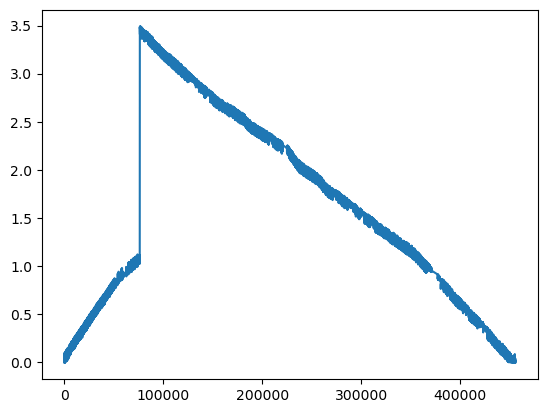

In [17]:
plt.plot(filtered_VT['tdiff_f1'])

In [18]:
#Mac
meas_path = pathlib.Path("/Users/coenberns/Library/CloudStorage/OneDrive-MassGeneralBrigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")

# #Windows
# meas_path = pathlib.Path("C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")
# # List all the files in the selected folder
in_folder = [f for f in meas_path.iterdir() if f.is_file()]

# Print a list of available files
for i, f in enumerate(in_folder, start=1):
    print(f"{i}. {f.name}")

# Ask the user to choose a file
while True:
    try:
        choice = int(input("Enter the number of the file you want to use (1,2, etc.): "))
        if 1 <= choice <= len(in_folder):
            break
        else:
            print("Invalid choice. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Assign the selected file to a variable
file = in_folder[choice - 1]

# Now you can work with the selected_file
print(f"File selected: {file.name}")

1. 08282023_Ambulation.txt
2. 08282023_beginwithsleep.txt
3. 08282023_beforemidnight-noon_day1-2.txt
4. .DS_Store
5. 08282023_firstpartambu_noglitch.txt
6. 08282023_smallpartbegin_at2pm.txt
7. 08282023_smallest_fortesting.txt
8. 08282023_Ambulation_secondpart.txt
9. 08282023_5plushoursevening1.txt
10. 08282023_aroundmidnight.txt
File selected: 08282023_firstpartambu_noglitch.txt


In [19]:
fulldat, VT_data, grouped_fulldat,\
    volt_fulldat, avg_time_between, effective_rate,\
        avg_wake_up_time, avg_sleep_time, avg_burst_time,\
            burst_times = read_egg_v3_lowerP(file,
                                            header=0,
                                            rate=62.5,
                                            scale=600,
                                            error=0,
                                            date=None,
                                            n_burst=5,
                                            sleep_ping=1,
                                            sleep_time=1.84,
                                            t_deviation=0.2,
                                            start_sleep=142,
                                            n_missing=1,
                                            mean=False
                                            )

reading csv file time:  0.12545514106750488
Initial data conversion:  0.06538987159729004
flip -65535 1
Time for new counter:  0.29404592514038086
elapsed t could be printed!!!!
0              0 days 00:00:00
1       0 days 00:00:59.999000
2       0 days 00:01:59.998000
3       0 days 00:02:59.996000
4       0 days 00:04:59.995000
                 ...          
50708   0 days 09:23:41.267000
50709   0 days 09:23:41.346000
50710   0 days 09:23:41.346000
50711   0 days 09:23:41.346000
50712   0 days 09:23:41.346000
Name: elapsed_t, Length: 50713, dtype: timedelta64[ns]
Time for datetime conversion : 0.16323590278625488
Time for hexdat:  0.490588903427124
                     realtime  misc   packet  \
0     2023-08-28 12:09:05.310   0a     0099    
1     2023-08-28 12:10:05.309   0a     0100    
2     2023-08-28 12:11:05.308   0a     0101    
3     2023-08-28 12:12:05.306   0a     0102    
4     2023-08-28 12:14:05.305   0a     0104    
...                       ...   ...      ...   
507

In [20]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-20-219bd2590633>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-20-219bd2590633>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-20-219bd2590633>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [21]:
#Mac
meas_path = pathlib.Path("/Users/coenberns/Library/CloudStorage/OneDrive-MassGeneralBrigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")

# #Windows
# meas_path = pathlib.Path("C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/Pig measurements/08282023 second - straight measurement mode 2")
# # List all the files in the selected folder
in_folder = [f for f in meas_path.iterdir() if f.is_file()]

# Print a list of available files
for i, f in enumerate(in_folder, start=1):
    print(f"{i}. {f.name}")

# Ask the user to choose a file
while True:
    try:
        choice = int(input("Enter the number of the file you want to use (1,2, etc.): "))
        if 1 <= choice <= len(in_folder):
            break
        else:
            print("Invalid choice. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Assign the selected file to a variable
file = in_folder[choice - 1]

# Now you can work with the selected_file
print(f"File selected: {file.name}")

1. 08282023_Ambulation.txt
2. 08282023_beginwithsleep.txt
3. 08282023_beforemidnight-noon_day1-2.txt
4. .DS_Store
5. 08282023_firstpartambu_noglitch.txt
6. 08282023_smallpartbegin_at2pm.txt
7. 08282023_smallest_fortesting.txt
8. 08282023_Ambulation_secondpart.txt
9. 08282023_5plushoursevening1.txt
10. 08282023_aroundmidnight.txt
File selected: 08282023_Ambulation_secondpart.txt


In [22]:
#WORKING?? ASSIGN GROUP FUNCTION
# def assign_groups(df, n_burst=5, sleep_time=2, t_deviation=0.4, n_missing=1):
#     # Part from assign_groups
#     sleep_time_min = sleep_time - t_deviation
#     sleep_time_max = sleep_time + t_deviation

#     df['numeric_misc'] = np.select(
#         [df['misc'] == " 16 ", df['misc'] == " 0a ", df['misc'] == "miss"],
#         [1, 0, np.nan]
#     )
#     df['rolling_sum'] = df['numeric_misc'].rolling(n_burst).sum()
#     df['next_sleep'] = df['numeric_misc'].shift(-n_burst)
#     df['next_burst'] = df['numeric_misc'].shift(-n_burst-1)
#     df['next_time_diff'] = df['time_diff'].shift(-n_burst-1)
    
#     # Define conditions for grouping
#     cond1 = df['numeric_misc'] == 1
#     cond2 = df['next_sleep'] == 0
#     cond3 = df['next_burst'] == 1
#     cond4 = df['rolling_sum'] == n_burst
#     cond5 = (df['next_time_diff'] >= sleep_time_min) & (df['next_time_diff'] <= sleep_time_max)
#     cond6 = df['rolling_sum'] == n_burst -n_missing

#     valid_indices = df[cond1 & cond2 & cond3 & ((cond4 & cond5) | (cond6 & cond5))].index
#     groups = [np.nan] * len(df)
#     print(valid_indices)
#     for idx, start_idx in enumerate(valid_indices):
#         end_idx = start_idx + n_burst
#         groups[start_idx:end_idx] = [idx+1] * n_burst
#     df['group'] = groups
#     #df.drop(['next_sleep', 'next_burst', 'next_time_diff', 'rolling_sum', 'numeric_misc'], axis=1, inplace=True)
#     return df

#INITIAL ASSIGN GROUPS FUNCTION
def assign_groups(df, n_burst=5, sleep_time=2, t_deviation=0.2, n_missing=1):
    """
    Standardized grouping of the low power transmission scheme using packet bursts / sleeping cycles

    n_burst: Number of recordings SENT to receiver per recording/sleep cycle
    sleep_time: amount of time the device sleeps in between recordings (in seconds)
    t_deviation: variable to define allowed deviation from sleep_time
    n_missing: amount of packets in burst that can have a NaN value after the first transmission

    Packets are grouped based on the following:
        - There are n_burst consecutive recordings of voltages without errors 
        - Sleep transmission in between
        - Consecutive value after sleep is a transmission of a packet containing voltages again
        - Exception to the rule: n_missing amount of packets in the recording contain a NaN value
        - Possibly, after the sleep transmission; next burst can have a "non-transmission" value (i.e. 'miss')
    """
    group = 0
    # List to hold group numbers
    groups = [np.nan] * len(df)
    sleep_time_min = sleep_time - t_deviation
    sleep_time_max = sleep_time + t_deviation

    for i in range(len(df) - n_burst-1):

        if df['misc'].iloc[i] == " 16 ":
            next_n_values = df['misc'].iloc[i+1:i+n_burst-1].tolist()

            # Check to see not last potential group of data
            if i <= len(df) - n_burst:
                sleep_value = df['misc'].iloc[i+n_burst]
                new_burst_value = df['misc'].iloc[i+n_burst+1]
                time_diff = df['time_diff'].iloc[i+n_burst+1]

                if all(val == " 16 " for val in next_n_values) and sleep_value == " 0a " and new_burst_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                    group += 1
                    groups[i:i+n_burst] = [group] * n_burst

                elif sum(val == "miss" for val in next_n_values) <= n_missing and sleep_value == " 0a " and new_burst_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                    group += 1
                    groups[i:i+n_burst] = [group] * n_burst

            # Check for potential last group in data
            elif i == len(df) - n_burst+1 and all(val == " 16 " for val in next_n_values):
                group += 1
                groups[i:i+(n_burst-1)] = [group] * n_burst

    df['group'] = groups
    return df

In [23]:
#INITIAL TIME DIFFERENCE CALCULATIONS
def avg_time_diffs(df, n_burst=5, sleep_time=2, t_deviation=0.2):
    """
    Calcutating the effective sampling rate, using the values of average time differences
    between i) bursts and ii) sleep packets (to get the most reliable average). 
    Average wake up time as additional output. For conversion to low power mode, due to 
    rec/sleep cycling the sampling rate is slightly altered. This needs to be taken into 
    account to make sure the received values of the times and voltages can be used for 
    further analysis. 

    Inputs:     
        n_burst: Number of recordings SENT to receiver per recording/sleep cycle
        sleep_time: amount of time the device sleeps in between recordings (in seconds)
        t_deviation: variable to define allowed deviation from sleep_time

    Outputs:
        avg_burst_diff: Average time between the average burst difference
        avg_sleep_time: Average time between sleep packets received
        avg_wake_up_time: Average time between the sleep packet and new transmission - sleep time 
        effective_rate: the effective sampling rate
        - 
    """

    df_burst = df.copy()
    df_sleep = df.copy()
    sleep_time_min = sleep_time - t_deviation
    sleep_time_max = sleep_time + t_deviation

    # Calculate the average wake up time based on the sleep time and the time difference between sleep and next packet
    sleep_times = []
    wake_up_times = []
    for i in range(len(df_sleep)-1):
        if df_sleep['misc'].iloc[i] == " 0a ":
            next_value = df_sleep['misc'].iloc[i+1]
            time_diff = df_sleep['time_diff'].iloc[i+1]
            if next_value == " 16 " and (sleep_time_min <= time_diff <= sleep_time_max):
                sleep_times.append(time_diff)
                wake_up_time = time_diff - sleep_time
                wake_up_times.append(wake_up_time)

    if sleep_times:
        avg_sleep_time = sum(sleep_times)/len(sleep_times)
    else:
        sleep_times = 0
    
    if wake_up_times:
        avg_wake_up_time = sum(wake_up_times)/len(wake_up_times)
    else:
        avg_wake_up_time = 0

    burst_times = []
    for i in range(len(df_burst)-n_burst-1):
        if (df_burst['misc'].iloc[i] == " 16 ") and (not np.isnan(df_burst['group'].iloc[i])):
            first_burst = df_burst['packet_re_idx'].iloc[i]
            last_burst = df_burst['packet_re_idx'].iloc[i+n_burst-1]

            # Check if all values in the range are "16"
            next_value_cat = df_burst['misc'].iloc[i+1:i+n_burst]
            if all(val == " 16 " for val in next_value_cat):
                
                next_values = df_burst['time_diff'].iloc[i+1:i+n_burst]
                if (last_burst - first_burst == n_burst - 1):
                    burst_times.append(next_values.sum())
    if burst_times:
        avg_burst_time = sum(burst_times)/len(burst_times)
    else:
        avg_burst_time = 0
    # Average time between sample bursts and effective sampling rate in SPS
    #avg_time_between = np.mean([avg_burst_diff, avg_sleep_time])
    avg_time_between = avg_burst_time+avg_sleep_time
    effective_rate = 1 / avg_time_between

    return avg_time_between, effective_rate, avg_wake_up_time, avg_sleep_time, avg_burst_time, burst_times

In [24]:
    ## COMMENTED OUT FOR NOW
    #         
    # # Calculate the time difference between the different sleep transmissions
    # # Dataframe with only sleep packets
    # # df_sleep = df_sleep[df_sleep['misc'] == " 0a "]
    # # # Calculate time difference in between sleep packets
    # # # df_sleep['time_diff'] = df_sleep['realtime'].diff().dt.total_seconds()
    # # # df_sleep = df_sleep[df_sleep['time_diff'] >= sleep_time_min]
    # # # df_sleep = df_sleep[df_sleep['time_diff'] <= sleep_time_max]
    # # # avg_sleep_time = df_sleep['time_diff'].mean()
    # # Calculate the sum of time differences per group to average per groups, then calculate the time average between these
    # # Filter out group = nan rows for burst groups
    # df_burst.dropna(subset=['group'], inplace=True)
    # # Calculate summed delta t per group
    # group_time_diff = df_burst.groupby('group')['time_diff'].sum()
    # # Identify valid groups where summed delta t
    # valid_groups = group_time_diff[(group_time_diff >= sleep_time_min) & (
    #     group_time_diff <= sleep_time_max)].index.tolist()
    # # Filter out invalid groups
    # df_burst = df_burst[df_burst['group'].isin(valid_groups)]
    # # Assign the  summed delta t per group back to df_burst for potential later use
    # df_burst['group_time_diff'] = df_burst['group'].map(group_time_diff)
    # # Calculate the average time difference across valid groups
    # avg_burst_diff = group_time_diff[valid_groups].mean()

In [25]:
#MASTER FUNCTION
def read_egg_v3_lowerP(file,
                       header=0,
                       rate = 62.5,
                       scale=600,
                       error=0,
                       date=None,
                       n_burst=5,
                       sleep_ping=1,
                       sleep_time=2,
                       t_deviation=0.2,
                       start_sleep=240,
                       n_missing=1,
                       mean = True):
    """
    This function reads in and preprocesses the data from a text file generated by smartRF from 
    EGG_V3 when the recording mode is set to low power mode (Mode 2 or 3). 
    Inputs: 
        file : filepath of the target txt file
        header : Number of lines to skip
        scale : +- scale in mV 
        error : returns data with CRC errors. Default is 0 so those are stripped
        date : The date of the recording (automatically fetched if in beginning of txt file if format: MMDDYYYY_textfilename.txt)
        n_burst: Number of recordings SENT to receiver per recording/sleep cycle
        sleep_time: amount of time the device sleeps in between recordings (in seconds)
        t_deviation: variable to define allowed deviation from sleep_time
        n_missing: amount of packets in burst that can have a NaN value after the first transmission

    Outputs:
        VT_data: Voltage time data, use timestamps for time (others are indication of functionality, first two can be left out)
            .avg_elapsed_t: datetime object which contains the average elapsed time of a group (1, just for indication of difference)
            .avg_elapsed_s: The average elapsed time of the group, from start, in seconds (2, just for indication of difference)
            .packet_re_idx: The re-indexed packet number (zero is first voltage packet, note: this can be renamed "counter" if necessary)
            .group: group numbers based on the assign_groups() function 
            .Channel {i}: mean voltage per group for all channels
            .timestamps: The evenly spaced time variable, based on avg_time_between and the packet number divided by 6
        grouped_fulldat: The full dataset, grouped based on the assign_groups() function
        volt_fulldat: The dataset including all voltages, average and raw and all other columns as in grouped_fulldat (sleep and missing are dropped)
        avg_time_between: The average time between the sample bursts as calculated by avg_time_diffs() 
        effective_rate: The effective sampling rate based on the avg_time_between(*) (=1/*)

    """
    complete_start = time.time()
    # Putting in the date information to create complete datetime object, if information available
    if date is None:
        # get only the filename from the file path
        file_path = pathlib.Path(file)
        filename = file_path.name
        # extract date from the filename
        date = filename.split('_')[0]

    # Creating datetime object
    # which takes in "MMDDYYYY" like only US people write date order
    date = datetime.strptime(date, '%m%d%Y')
    start_time1 = time.time()
    dat = pd.read_csv(file, header=0, dtype=str, delimiter='|', names=[
        'realtime', 'misc', 'packet', 'msg', 'rssi'])
    end_time1 = time.time()
    print("reading csv file time: ", end_time1-start_time1)

    start_timer_dat = time.time()
    dat = dat[~dat.rssi.str.contains('error')]
    dat = dat[dat.misc.str.contains('16') | dat.misc.str.contains('0a')]
    dat = dat.reset_index(drop=True)
    end_timer_dat = time.time()
    print("Initial data conversion: ", end_timer_dat-start_timer_dat)
    counter_timer = time.time()
    counter = dat.packet.astype(int)
    new_counter = [0]
    for j, ele in enumerate(counter[1:]):
        step = counter[j+1]-counter[j]
        if step > 0:
            new_counter.append(step+new_counter[j])
        else:
            new_counter.append(65536-counter[j]+counter[j+1]+new_counter[j])
            print('flip', step, 65536-counter[j]+counter[j+1])
    abscounterseries = pd.Series(new_counter, name='packet_re_idx')
    counter_end_timer = time.time()
    print("Time for new counter: ", counter_end_timer-counter_timer)

    dat = pd.concat((dat, abscounterseries), axis=1)
    
    
    # Creating a datetime object from realtime, recalling it realtime (since it still is)
    datetime_counter = time.time()
    dat["realtime"] = dat["realtime"].str.strip()
    dat["realtime"] = pd.to_datetime(dat["realtime"], format='%H:%M:%S.%f')
    dat["realtime"] = dat["realtime"].apply(
        lambda t: datetime.combine(date, t.time()))
    # Check for date rollover and increment the date if necessary, with additional glitch values excluded
    dat['time_diff'] = dat['realtime'].diff().dt.total_seconds()
    dat['rollover'] = dat['time_diff'] < 0
    dat['glitch'] = (dat['time_diff'] > -5) & (dat['rollover'])

    n_glitch = 50
    dat['glitch'] = dat['glitch'].rolling(window=n_glitch, min_periods=1).max().astype(bool)
    dat.loc[dat['glitch'], 'realtime'] = np.nan
    dat['correct_rollover'] = dat['rollover'] & ~dat['glitch'] 
    dat['days_to_add'] = dat['correct_rollover'].cumsum()
    dat['corrected_realtime'] = dat['realtime'] + pd.to_timedelta(dat['days_to_add'], unit='D')
    # dat['corrected_realtime'].interpolate(method='linear', inplace=True)

    # probably delete this if timestamps values at end are close to elapsed_s
    dat['elapsed_t'] = dat['corrected_realtime'] - dat['corrected_realtime'].iloc[0]
    print("elapsed t could be printed!!!!")
    print(dat['elapsed_t'])
    datetime_end_counter = time.time()
    print("Time for datetime conversion :", datetime_end_counter-datetime_counter)

    hexdat_counter = time.time()
    dat_col = dat.msg
    # Return list of splits based on spaces in msg
    hexdat = dat_col.str.split(' ')
    serieslist = []
    sleep_pings = []  # List to store sleep pings
    for k, ele in enumerate(hexdat):
        if len(ele) == 23:  # Only select those that have the correct length for voltage data
            vlist = []
            for i in range(0, 10):
                n = i*2 + 2
                value = ''.join(['0x', ele[n], ele[n-1]])
                hvalue = int(value, 16)
                if i == 0:
                    vlist.append(hvalue)  # append hex code
                else:
                    if hvalue < 2**15:
                        vlist.append(scale*float(hvalue)/(2**15))
                    else:
                        vlist.append(scale*(((float(hvalue)-2**16)/(2**15))))
        elif len(ele) == 11:  # This is a sleep packet
            # Extract the number of pings from the first two bytes of the message and convert to integer
            ping_value = int(''.join(['0x', ele[1], ele[0]]), 16)
            sleep_pings.append(ping_value)
            # Fill the remaining places with None to maintain vlist structure
            vlist = [ping_value] + [None]*9
        else:  # Error in packet structure
            print('Line Error!' + str(k))
            print(ele)
            vlist = []  # add empty list on error
        serieslist.append(vlist)
    hexdat_end_counter = time.time()
    print("Time for hexdat: ", hexdat_end_counter-hexdat_counter)
    collist = ['SPI']
    for i in range(8):
        collist.append('Channel '+str(i))  # make channel list name
    collist.append('CRC')
    datalist = pd.DataFrame(serieslist, columns=collist)
    # print(datalist)
    fulldat = pd.concat((dat, datalist), axis=1)
    print(fulldat)
    missing_packets_counter = time.time()
    # packet counter with actual packet values, seeing if we miss packets
    expected_packets = list(
        range(min(fulldat['packet_re_idx']), max(fulldat['packet_re_idx'])+1))
    missing_packets = list(set(expected_packets) - set(fulldat['packet_re_idx'].to_list()))
    missing_rows = pd.DataFrame(
        [{'misc': 'miss', 'packet_re_idx': re_idx} for re_idx in missing_packets])
    fulldat = pd.concat([fulldat, missing_rows], ignore_index=True)
    fulldat = fulldat.sort_values(by='packet_re_idx').reset_index(drop=True)
    missing_packet_end_counter = time.time()
    print("missing packets: ", missing_packet_end_counter-missing_packets_counter)
    # Assigning groups to fulldat valid bursts
    start_time2=time.time()
    grouped_fulldat = assign_groups(fulldat,
                                    n_burst=n_burst,
                                    sleep_time=sleep_time,
                                    t_deviation=t_deviation,
                                    n_missing=n_missing)
    end_time2=time.time()
    print("grouping function: ", end_time2-start_time2)
    start_avg_times = time.time()
    avg_time_between, effective_rate, avg_wake_up_time,\
        avg_sleep_time, avg_burst_time, burst_times = avg_time_diffs(df=fulldat,
                                                                    n_burst=n_burst,
                                                                    sleep_time=sleep_time,
                                                                    t_deviation=t_deviation
                                                                    )                                        
    end_avg_times = time.time()
    print("Calculating average times: ", end_avg_times-start_avg_times)
    #CONDITION IF WE WANT MEAN VALUES
    if mean == True:
        # Final processing steps
        volt_fulldat = grouped_fulldat.copy()
        # Don't know how to change since timestamps dependent on re-indexing to first voltage value
        volt_fulldat = volt_fulldat.dropna()
        volt_fulldat['avg_elapsed_t'] = volt_fulldat.groupby(
            'group')['elapsed_t'].transform('mean')
        volt_fulldat['avg_elapsed_start'] = volt_fulldat['avg_elapsed_t'] - \
            volt_fulldat['avg_elapsed_t'].iloc[0]
        volt_fulldat['avg_elapsed_s'] = volt_fulldat['avg_elapsed_start'].dt.total_seconds()
        # # Storing RAW voltage data just in case
        # for i in range(8):
        #     volt_fulldat[f'RAW Channel {i}'] = volt_fulldat[f'Channel {i}']
        # Mean voltage calculations
        for i in range(8):
            channel = f'Channel {i}'
            # Calculate mean and directly store in the Channel columns, overwriting old data
            volt_fulldat[channel] = volt_fulldat.groupby(
                'group')[channel].transform('mean')
        # calculation of timestamps based on function, would like to put here
        volt_fulldat['packet_re_idx'] = volt_fulldat['packet_re_idx'] - \
            volt_fulldat['packet_re_idx'].iloc[0]
        #Introduce again the missing packets when they are divisible by 6
        expected_packets_mean = list(
            range(min(volt_fulldat['packet_re_idx']), max(volt_fulldat['packet_re_idx']) + 1))
        print("All expected packets: ", expected_packets_mean)
        missing_packets_mean = list(set(expected_packets_mean) - 
                                    set(volt_fulldat['packet_re_idx'].to_list()))
        missing_packets_divisible = [pkt for pkt in missing_packets_mean if pkt % (n_burst+1) == 0]
        print("Divisible packets: ", missing_packets_divisible)
        missing_rows_mean = pd.DataFrame(
            [{'misc': 'miss', 'packet_re_idx': re_idx} for re_idx in missing_packets_divisible]
        )
        print("Missing row dataframe: ", missing_rows_mean)
        volt_fulldat = pd.concat([volt_fulldat, missing_rows_mean], ignore_index=True)
        volt_fulldat = volt_fulldat.sort_values(by='packet_re_idx').reset_index(drop=True)
        volt_fulldat['timestamps'] = volt_fulldat['packet_re_idx'] / \
            ((n_burst+1))*avg_time_between
        #Dropping all the duplicates, but still keep the newly introduced na values (with timestamps)
        mask = (~volt_fulldat['group'].duplicated(keep='first')) | volt_fulldat['group'].isna()
        volt_fulldat = volt_fulldat[mask]
        #correcting for the final value difference using delta_t at the end
        delta_t_finish = (abs(volt_fulldat['avg_elapsed_s'].max()-volt_fulldat['timestamps'].max())/((volt_fulldat['packet_re_idx'].max()/6)-1))*(n_burst+1)

        # Initialize a new column to store the updated timestamps
        volt_fulldat['new_timestamps'] = volt_fulldat['timestamps']

        # Counter for the number of times add_value should be added
        counter = 0

        # Iterate over the DataFrame by index
        for idx in volt_fulldat.index:
            # If the current index is in packet_re_idx, add add_value to the 'new_timestamps' column
            if idx % 6 == 0:  # Adjust the condition based on your requirement
                counter += 1
            # Update the 'new_timestamps' by adding add_value multiplied by the counter
            volt_fulldat.at[idx, 'new_timestamps'] += delta_t_finish * counter

        datcols = ['corrected_realtime','avg_elapsed_s', 'timestamps',
                'packet_re_idx', 'group'] + [f'Channel {i}' for i in range(8)]
        # Calculating Voltage time data
        VT_data = volt_fulldat[datcols]
    #NON-MEAN PRE-PROCESSING
    else:
        grouped_fulldat1 = grouped_fulldat[grouped_fulldat['misc'] == " 16 "]
        groupdat = grouped_fulldat1.copy()
        groupdat['packet_re_idx'] = groupdat['packet_re_idx']-groupdat['packet_re_idx'].iloc[0]
        groupdat['packet_start_idx'] = groupdat['packet_re_idx']
        expected_packets = list(
        range(min(groupdat['packet_start_idx']), max(groupdat['packet_start_idx'])+1))
        missing_packets = list(set(expected_packets) - set(groupdat['packet_start_idx'].to_list()))
        missing_rows = pd.DataFrame(
        [{'misc': 'miss', 'packet_start_idx': re_idx} for re_idx in missing_packets])
        groupdat = pd.concat([groupdat, missing_rows], ignore_index=True)
        groupdat = groupdat.sort_values(by='packet_start_idx').reset_index(drop=True)
        #Time projection function 1 - including correction
        tarray = []
        for number in groupdat['packet_start_idx']:
            burst_time = np.floor((number)/(n_burst+sleep_ping))*avg_time_between
            packet_time = ((number) % (n_burst+sleep_ping))*(avg_burst_time/(n_burst-1))
            tarray.append(float(burst_time)+packet_time)
        
        tseries = pd.Series(tarray,name='timestamps_f1')
        groupdat['elapsed_t'] = groupdat['elapsed_t']-groupdat['elapsed_t'].iloc[0]
        groupdat['elapsed_s'] = groupdat['elapsed_t'].dt.total_seconds()
        volt_fulldat = groupdat.reset_index(drop=True)
        volt_fulldat = pd.concat((volt_fulldat,tseries), axis=1)
        delta_t_finish = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f1'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_series = pd.Series([delta_t_finish]*len(volt_fulldat))
        delta_t_series = delta_t_series.cumsum()
        delta_t_series -= delta_t_finish
        volt_fulldat['corrected_t_f1'] = volt_fulldat['timestamps_f1'] + delta_t_series
        
        #Time projection function 2 - including correction
        t_cycle = (volt_fulldat['elapsed_s'].max()/volt_fulldat['packet_start_idx'].max())*6
        tarray_2 = []
        for number2 in groupdat['packet_start_idx']:
            burst_time2 = np.floor((number2)/(n_burst+sleep_ping))*t_cycle
            packet_time2 = ((number2) % (n_burst+sleep_ping))*(1/rate)
            tarray_2.append(float(burst_time2)+packet_time2)
        tseries2 = pd.Series(tarray_2, name='timestamps_f2')
        #Time projection function 3 - including correction
        tarray_3 = []
        for number3 in groupdat['packet_start_idx']:
            burst_time3 = np.floor((number3)/(n_burst+sleep_ping))*t_cycle
            packet_time3 = ((number3) % (n_burst+sleep_ping))*(avg_burst_time/(n_burst-1))
            tarray_3.append(float(burst_time3)+packet_time3)
        tseries3 = pd.Series(tarray_3, name='timestamps_f3')

        #For function 2
        volt_fulldat = pd.concat([volt_fulldat,tseries2,tseries3],axis=1)
        delta_t_f2 = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f2'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_f2_series = pd.Series([delta_t_f2]*len(volt_fulldat))
        delta_t_f2_series = delta_t_f2_series.cumsum()
        delta_t_f2_series -= delta_t_f2
        volt_fulldat['corrected_t_f2'] = volt_fulldat['timestamps_f2']+delta_t_f2_series
        delta_t_f3 = abs(volt_fulldat['elapsed_s'].max()-volt_fulldat['timestamps_f3'].max())/(volt_fulldat['packet_start_idx'].max()-1)
        delta_t_f3_series = pd.Series([delta_t_f3]*len(volt_fulldat))
        delta_t_f3_series = delta_t_f3_series.cumsum()
        delta_t_f3_series -= delta_t_f3
        volt_fulldat['corrected_t_f3'] = volt_fulldat['timestamps_f3']+delta_t_f3_series
        datcols = ['corrected_realtime','elapsed_s','timestamps_f1','timestamps_f2','timestamps_f3', 
                   'corrected_t_f1','corrected_t_f2', 'corrected_t_f3', 'packet_start_idx'] + [f'Channel {i}' for i in range(8)]
        VT_data = volt_fulldat[datcols]


    complete_end = time.time()
    print("Total time to complete function: ", complete_end-complete_start)

    return fulldat, VT_data, grouped_fulldat, \
        volt_fulldat, avg_time_between, effective_rate,\
            avg_wake_up_time, avg_sleep_time, avg_burst_time, burst_times

In [26]:
fulldat, VT_data, grouped_fulldat,\
    volt_fulldat, avg_time_between, effective_rate,\
        avg_wake_up_time, avg_sleep_time, avg_burst_time,\
            burst_times = read_egg_v3_lowerP(file,
                                            header=0,
                                            rate=62.5,
                                            scale=600,
                                            error=0,
                                            date=None,
                                            n_burst=5,
                                            sleep_ping=1,
                                            sleep_time=1.84,
                                            t_deviation=0.2,
                                            start_sleep=142,
                                            n_missing=1,
                                            mean=False
                                            )

reading csv file time:  0.3451073169708252
Initial data conversion:  0.2467041015625
flip -65361 175
flip -65535 1
flip -65535 1
flip -65498 38
flip -65535 1
Time for new counter:  1.278076171875
elapsed t could be printed!!!!
0               0 days 00:00:00
1               0 days 00:00:00
2        0 days 00:00:00.032000
3        0 days 00:00:00.032000
4        0 days 00:00:00.032000
                  ...          
194379   1 days 11:01:50.191000
194380   1 days 11:01:52.136000
194381   1 days 11:01:52.184000
194382   1 days 11:01:52.231000
194383   1 days 11:01:52.231000
Name: elapsed_t, Length: 194384, dtype: timedelta64[ns]
Time for datetime conversion : 0.7815301418304443
Time for hexdat:  1.9403080940246582
                      realtime  misc   packet  \
0      2023-08-28 21:32:50.078   16    10882    
1      2023-08-28 21:32:50.078   16    10883    
2      2023-08-28 21:32:50.110   16    10884    
3      2023-08-28 21:32:50.110   16    10885    
4      2023-08-28 21:32:50.110   

In [27]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-27-219bd2590633>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-27-219bd2590633>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-27-219bd2590633>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

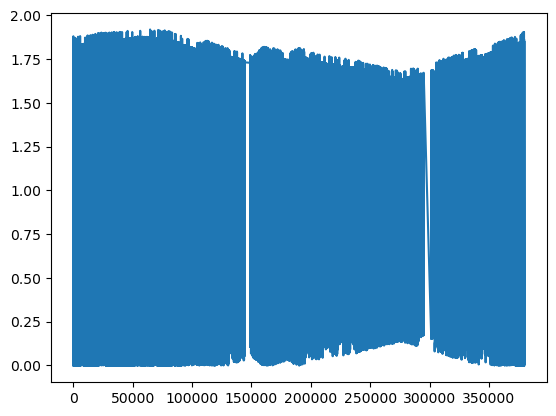

In [28]:
plt.plot(filtered_VT['tdiff_f1'])

In [29]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT([filtered_VT['tdiff_f1'] < 1] & [filtered_VT['tdiff_f2'] < 1] & [filtered_VT['tdiff_f3'] < 1])
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-29-b1fbcb5fc747>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-29-b1fbcb5fc747>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-29-b1fbcb5fc747>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

TypeError: unsupported operand type(s) for &: 'list' and 'list'

In [30]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT([filtered_VT['tdiff_f1'] < 1])
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-30-b334d9a78397>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-30-b334d9a78397>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-30-b334d9a78397>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

TypeError: 'DataFrame' object is not callable

In [31]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT[filtered_VT['tdiff_f1'] < 1]
rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-31-fe3a89dd8a6a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-31-fe3a89dd8a6a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-31-fe3a89dd8a6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [32]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT[filtered_VT['tdiff_f1'] < 1.6]
filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]
filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]

rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-32-e6e710cced01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-32-e6e710cced01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-32-e6e710cced01>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [33]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]
filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT[filtered_VT['tdiff_f1'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]

rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-33-159832ca29cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
<ipython-input-33-159832ca29cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
<ipython-input-33-159832ca29cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [34]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]

filtered_VT['initdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f1'])
filtered_VT['initdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f2'])
filtered_VT['initdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f3'])


filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT[filtered_VT['tdiff_f1'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]

rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-34-81a0660fd70c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['initdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f1'])
<ipython-input-34-81a0660fd70c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['initdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f2'])
<ipython-input-34-81a0660fd70c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [35]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]

filtered_VT['initdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f1'])
filtered_VT['initdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f2'])
filtered_VT['initdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f3'])


filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT[filtered_VT['tdiff_f1'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]

def rmse(diff):
    rmsd = np.sqrt(np.mean(diff ** 2)) 
    return rmsd

rmse_init1 = rmse(filtered_VT['initdiff_f1'])
rmse_init2 = rmse(filtered_VT['initdiff_f2'])
rmse_init3 = rmse(filtered_VT['initdiff_f3'])




rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

<ipython-input-35-d93d823be23c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['initdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f1'])
<ipython-input-35-d93d823be23c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['initdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f2'])
<ipython-input-35-d93d823be23c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

<ipython-input-36-404f3e6f9975>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['initdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f1'])
<ipython-input-36-404f3e6f9975>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VT['initdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f2'])
<ipython-input-36-404f3e6f9975>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

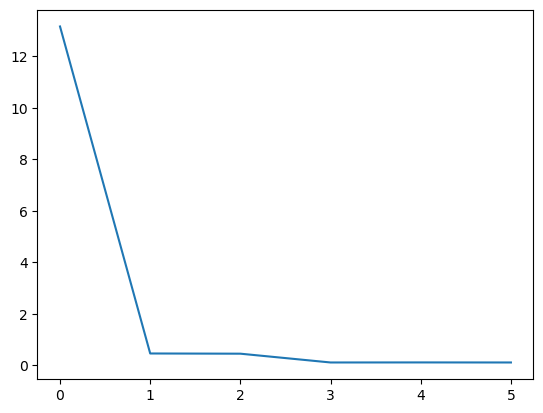

In [36]:
filtered_VT = VT_data[~VT_data['elapsed_s'].isna()]

filtered_VT['initdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f1'])
filtered_VT['initdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f2'])
filtered_VT['initdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['timestamps_f3'])


filtered_VT['tdiff_f1'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f1'])
filtered_VT['tdiff_f2'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f2'])
filtered_VT['tdiff_f3'] = abs(filtered_VT['elapsed_s']-filtered_VT['corrected_t_f3'])
filtered_VT = filtered_VT[filtered_VT['tdiff_f1'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]
# filtered_VT = filtered_VT[filtered_VT['tdiff_f2'] < 1.6]

def rmse(diff):
    rmsd = np.sqrt(np.mean(diff ** 2)) 
    return rmsd

rmse_init1 = rmse(filtered_VT['initdiff_f1'])
rmse_init2 = rmse(filtered_VT['initdiff_f2'])
rmse_init3 = rmse(filtered_VT['initdiff_f3'])


rmse_f1 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f1'], squared=False)
rmse_f2 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f2'], squared=False)
rmse_f3 = mse(filtered_VT['elapsed_s'],filtered_VT['corrected_t_f3'], squared=False)

rmse_array = [rmse_init1,rmse_init2, rmse_init3, rmse_f1, rmse_f2, rmse_f3]

plt.plot(rmse_array)

No kernel connected